# 6. 작사가 인공지능 만들기

## 시퀀스 자료형
__시퀀스 자료형__
- 연속적으로 이어진 자료형들을 총칭하여 "시퀀스 자료형"이라고 부른다.
- 시퀀스 자료구조형에는 리스트가 있다.
- 문장이나 주가, 날짜, 심지어 드라마까지 시퀀스 자료형

## 통계적 활용
- 인공지능은 통계적으로 확률이 높은 단어를 선택해 문장을 완성한다. 
- 그러므로 많은 데이터가 곧 좋은 결과를 만든다.

__순환신경망(RNN)__
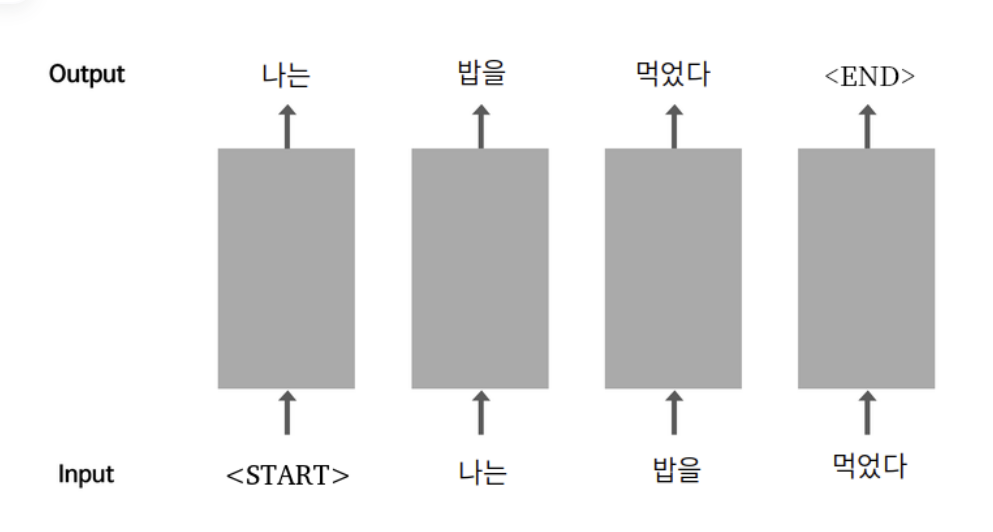

> 최초의 "나는" 이라는 단어를 생성하려면?
1. start라는 토큰을 추가해 줌으로써 해결
1. 문장을 완성하고 나면 인공지능은 end토큰을 던짐

In [1]:
sentence = " 나는 밥을 먹었다 "
# <start>는 문장의 시작 입니다. 
# <start> 토큰을 받은 순환 신경망은 "나는"을 출력한다.
# 출력된 "나는"이라는 단어를 다시 입력으로 사용하고 이러한 반복을 통해 "먹었다"까지 
# 글을 생성한다. 마지막으로 끝(완성)을 뜻하는 <end> 토큰을 생성하여 마무리 합니다. 
source_sentence = "<start>" + sentence
target_sentence = sentence + "<end>"

print("Source 문장:", source_sentence)
# Source 문장: <start> 나는 밥을 먹었다
print("Target 문장:", target_sentence)
# Target 문장:  나는 밥을 먹었다 <end>

Source 문장: <start> 나는 밥을 먹었다 
Target 문장:  나는 밥을 먹었다 <end>


문장 데이터들을 학습시키고 테스트 셋을 통해 특정 문장을 던져줬을때,  
> 어떤 문장이 나왔을때, 특정 문장이 나올 확률과 같이 조건부 확률을 이용하게 된다.   

## 실습(1) 데이터 다듬기

In [2]:
! mkdir -p ~/aiffel/lyricist/models # mkdir : make directory의 약자로서 디렉토리를 생성할 때 사용하는 명령어입니다. , -p : 상위 경로도 함께 생성 models 폴더를 생성할때 lyricist 폴더가 없으면 해당옵션이 없을시 에러발생
! ln -s ~/data ~/aiffel/lyricist/data #ln : Link 의 약자로서 리눅스 파일시스템에서 링크파일을 

준비된 데이터는 1mb남짓한 텍스트 파일. GPT-2는 100gb 이상

In [3]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# re: Regular Expression의 줄임말로, 파이썬 정규표현식을 사용하기 위한 모듈
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# tensorflow(TensorFlow): 데이터 흐름 프로그래밍을 위한 라이브러리. 데이터 그래프를 수치적으로 연산하기 위해 구글에서 만든 오픈 소스 라이브러리.
import os, re 
import numpy as np
import tensorflow as tf

# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

# 앞에서부터 10라인만 화면에 출력해 볼까요?
print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


In [4]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue # 길이가 0인 문장은 건너뜁니다. 
    if sentence[-1] == ":":continue # 문장의 끝이 : 인 문장은 건너뜁니다. 
        
    if idx > 9 : break # 일단 문장 10개만 확인해 볼 겁니다. 
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


텍스트 분류 모델에서 많이 보신 것처럼 텍스트 생성 모델에도 단어 사전을 만들게 됩니다.  
- 가장 간단한 방법은 띄어쓰기 기준

__이외의 문제__
1. 문장부호가 단어에 붙어 있어서 문장 부호 양쪽에 공백을 추가
1. 대문자 소문자를 다르게 인식하기 때문에 모든 문자를 소문자로 변환
1. 특수문자가 있어서 띄어쓴 단어들이 띄어쓰기가 안 된것으로 인식되는경우가 있어서 특수문자를 제거

In [114]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;Sample        sentence?"))

<start> this is sample sentence ? <end>


In [101]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

텐서플로우 모듈 활용 자연어 처리  
> tf.keras.preprocessing.text.Tokenizer

데이터를 숫자로 변환까지 한 방에 해줌
- 이 과정을 vectorize라 하며, 숫자로 변환된 데이터를 tensor라고 함

In [259]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f0454a52550>


In [260]:
len(corpus)

24015

In [261]:
len(tensor)

24015

In [262]:
tensor[7120]

array([   2,  143,   30,  116, 2543, 3839,   15,  237,   12,  240,    3,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [263]:
print(tensor[:3, :10])

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


In [264]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


In [265]:
tokenizer.index_word[11111]

'ditty'

In [299]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]   
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    # start 빼고

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


In [267]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

- 정규표현식을 이용한 corpus 생성
- tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환
- tf.data.Dataset.from_tensor_slices()를 이용해 tf.data.Dataset객체로 변환

## 실습(2) 인공지능 학습시키기

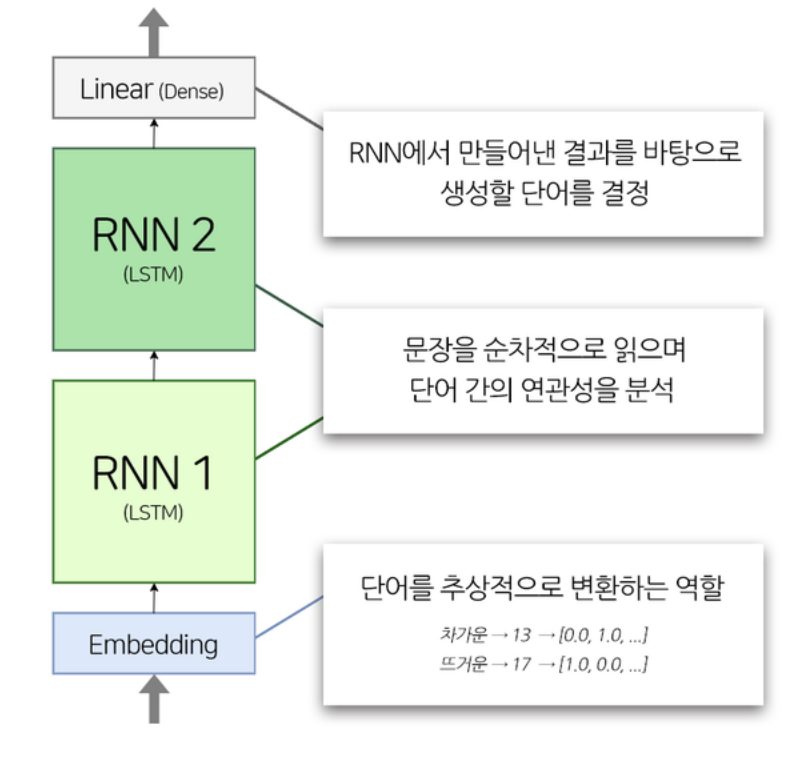

In [269]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 256 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

- embedding_size : 워드 벡터의 차원수, 단어가 추상적으로 표현되는 크기
- hidden_size : LSTM레이어의 hidden state의 차원수. 데이터가 적은데 너무 많으면 과적합이 될 수 있다.

In [295]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): 
#     print(src_sample, tgt_sample)
    break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[-9.15784476e-05, -1.97674686e-04,  1.02582031e-04, ...,
         -2.02944881e-04, -1.35621813e-04, -4.10077424e-04],
        [ 1.21999205e-04, -4.56347443e-05,  1.32650457e-04, ...,
         -2.01119154e-04, -4.01142286e-04, -8.60340195e-04],
        [ 3.07263515e-04, -1.07177861e-04,  3.28678580e-04, ...,
         -5.37573767e-04, -3.92980583e-04, -1.10963010e-03],
        ...,
        [ 3.50971543e-03,  1.58897578e-03,  8.93610064e-04, ...,
         -1.57141068e-03,  2.90706139e-05, -1.14842970e-03],
        [ 3.78020573e-03,  2.05902872e-03,  9.22899810e-04, ...,
         -1.63487147e-03,  2.24776464e-04, -1.35177188e-03],
        [ 3.98841547e-03,  2.45809811e-03,  9.46852786e-04, ...,
         -1.71754393e-03,  4.22835059e-04, -1.55881129e-03]],

       [[-9.15784476e-05, -1.97674686e-04,  1.02582031e-04, ...,
         -2.02944881e-04, -1.35621813e-04, -4.10077424e-04],
        [-1.03076243e-04, -5.40214358e-04,  2.

In [296]:
# 모델의 구조를 확인합니다.
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


In [297]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다

# Adam 알고리즘을 구현하는 optimzier이며 어떤 optimzier를 써야할지 모른다면 Adam을 쓰는 것도 방법이다.
# 우리가 학습을 할 때 최대한 틀리지 않는 방향으로 학습을 해야한다.
# 여기서 얼마나 틀리는지(loss)를 알게하는 함수가 손실함수 이다.
# 이 손실함수의 최소값을 찾는 것을 학습의 목표로 하며 여기서 최소값을 찾아가는 과정을 optimization 이라하고
# 이를 수행하는 알고리즘을 optimizer(최적화)라고 한다.

optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
model.fit(dataset, epochs=30) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.

Epoch 1/30
93/93 [==============================] - 46s 434ms/step - loss: 3.5044
Epoch 2/30
93/93 [==============================] - 39s 418ms/step - loss: 2.8113
Epoch 3/30
93/93 [==============================] - 40s 430ms/step - loss: 2.7167
Epoch 4/30
93/93 [==============================] - 40s 426ms/step - loss: 2.6188
Epoch 5/30
93/93 [==============================] - 40s 426ms/step - loss: 2.5496
Epoch 6/30
93/93 [==============================] - 40s 426ms/step - loss: 2.4960
Epoch 7/30
93/93 [==============================] - 40s 426ms/step - loss: 2.4405
Epoch 8/30
93/93 [==============================] - 40s 426ms/step - loss: 2.3899
Epoch 9/30
93/93 [==============================] - 40s 428ms/step - loss: 2.3451
Epoch 10/30
93/93 [==============================] - 40s 429ms/step - loss: 2.3004
Epoch 11/30
93/93 [==============================] - 39s 417ms/step - loss: 2.2578
Epoch 12/30
93/93 [==============================] - 40s 428ms/step - loss: 2.2183
Epoch 13/30
9

## 실습(3) 잘 만들어졌는지 평가하기

In [301]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [332]:
while True:
    sentence = input()
    gentext = generate_text(model, tokenizer, init_sentence = "<start> "+ sentence)
    print(gentext[8:-7])
    
    if sentence == "":
        print("프로그램 종료")
        break

Dear
dear my lord ,

and , by the cranks and offices of man ,
프로그램 종료
